# Twitter sentiment analysis

## Introduction

Sentiment analysis is a reccurent field in text processing, it can be used in various cases such as processing customer feedback, movies review, blocking specific messages that can hurt someone.
The idea is given a text be able to tell if that text is negative, neutral, or positive about its topic.
The same can be applied to tweets.

## How are we going to do that?
In order to process tweets, we have to convert them to something the neural network can understand, so we're going to convert text to fix lenght sequence. 
Then we use those sequence to learn on them in a neural network. The example here is very basic, we'll produce 3 model, the goal here is to compare the three models.
So we will split the data in three part the train, validation, and test data. We're going to make the model comparison using the test data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, GlobalMaxPool1D, Conv1D, LSTM, SpatialDropout1D
from keras.layers import Dropout, Bidirectional, BatchNormalization
import emoji
import nltk
from wordcloud import WordCloud, STOPWORDS

In [2]:
plt.style.use('ggplot')


## Loading data

In the target fields we have 3 values possible
* 0 is for negative
* 4 is for positive

we decided to switch the positives values to 1 so it can fit in our model

In [3]:
tweets_global = pd.read_csv("training.1600000.processed.noemoticon.csv", names=['target', 'id', 'date', 'flag', 'user', 'text'], encoding = 'latin', header=None)
tweets_global['target'].replace({4: 1}, inplace=True)

In [4]:
def cleaner(tweet):
   tweet = re.sub("@[A-Za-z0-9]+", "", tweet)  # Remove @ sign
   tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet)  # Remove http links
   tweet = " ".join(tweet.split())
   tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI)  # Remove Emojis
   tweet = tweet.replace("#", "").replace("_", " ")  # Remove hashtag sign but keep the text
   tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet))
   return tweet



In [5]:
tweets_global.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
tweets_global['target'].value_counts(normalize=True) * 100

0    50.0
1    50.0
Name: target, dtype: float64

We'll take a subset keeping the same proportion than in the original file. We want to keep the computations as fast as we can

In [7]:
tweets = pd.read_csv('training_set_small.csv', names=['target', 'id', 'date', 'flag', 'user', 'text'])

tweets['target'].replace({4: 1}, inplace=True)
tweets['text'] = tweets['text'].map(lambda x: cleaner(x))
text = tweets['text']
target = tweets['target']

## Visualizing the data

In [8]:
import string
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    

common_words={'oh','yo','ya','im','still','back','now','got','go','day','today','tomorrow','want','going','monday','tuesday','wednesday','thursday','friday','saturday','sunday','someone','first','last','didnt','u','stuff','cant'}
common_words= common_words.union(set(string.ascii_lowercase))

Here is the negative wordcloud

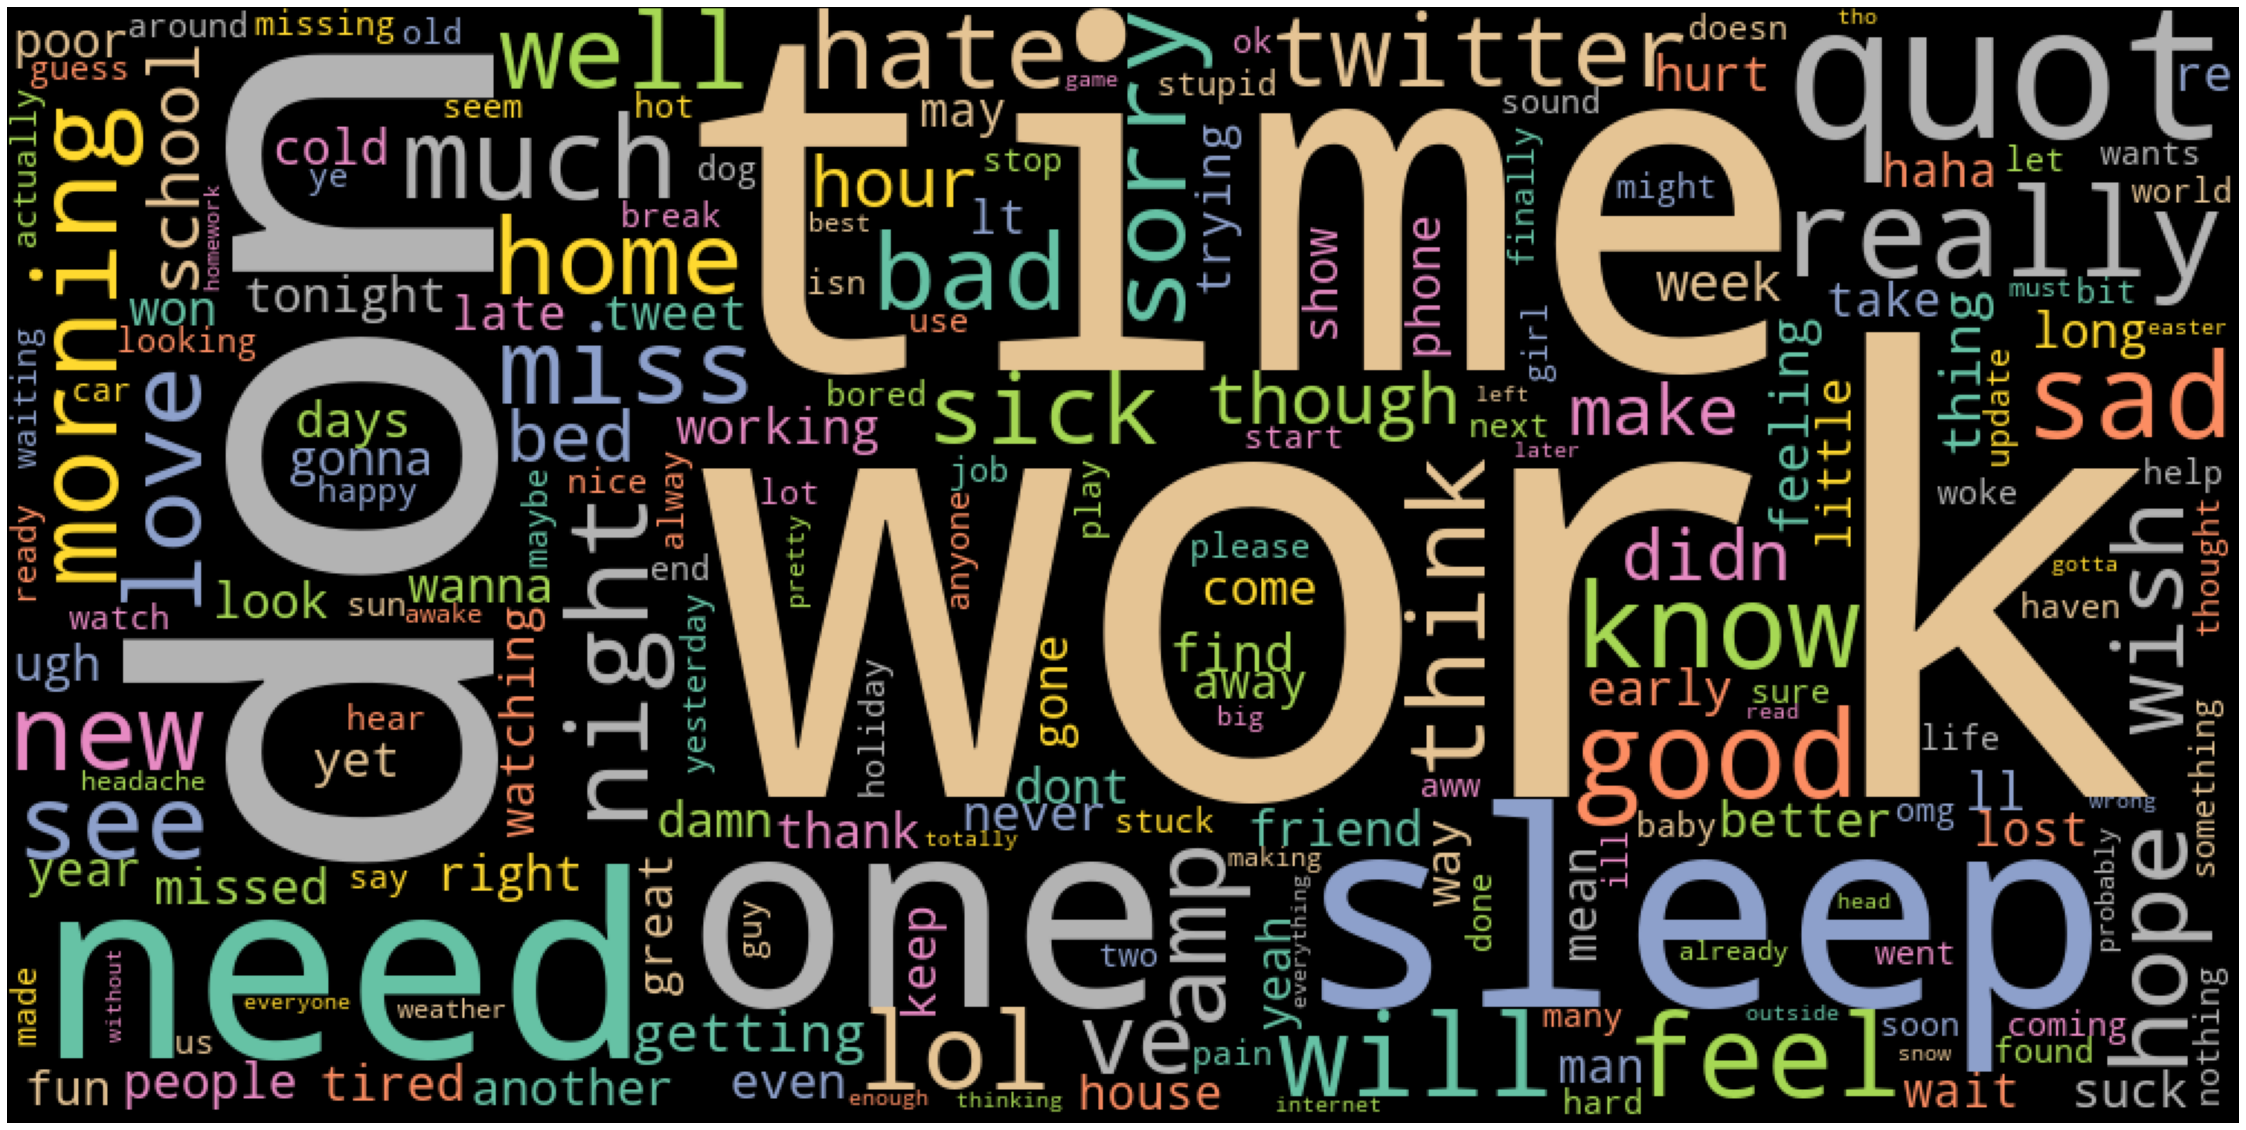

In [9]:
is_negative = tweets['target'] == 0
is_positive = tweets['target'] == 1

small_negatives = tweets[is_negative]
small_positives = tweets[is_positive]


text_global_negative = ' '.join([x.lower() for x in small_negatives['text']])

wordcloud_negative = WordCloud(width = 1000, height = 500, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = (STOPWORDS.union(common_words))).generate(text_global_negative)
plot_cloud(wordcloud_negative)

Here is the positive wordcloud

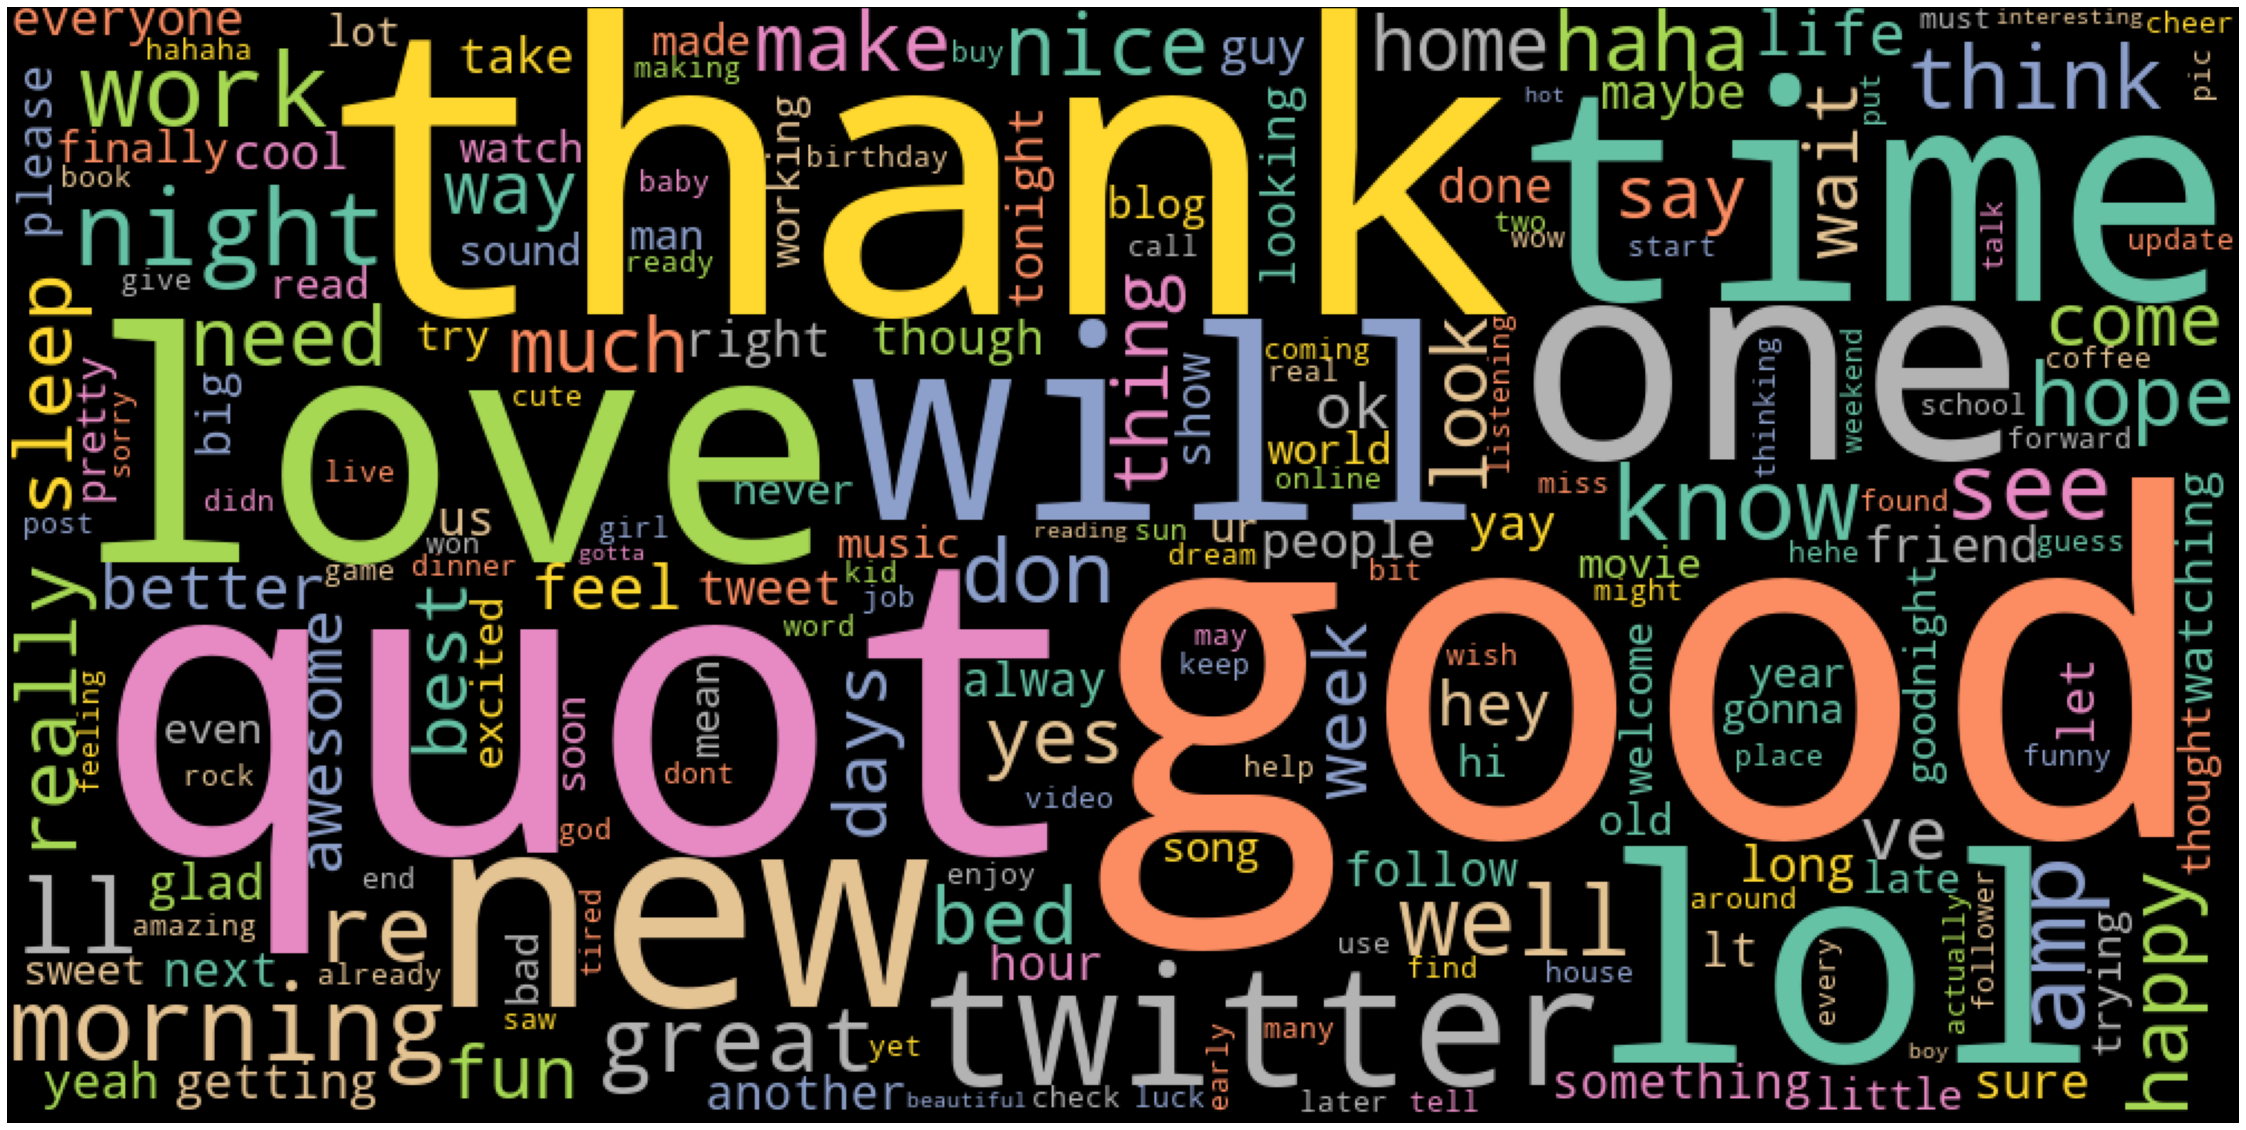

In [10]:
text_global_positive = ' '.join([x.lower() for x in small_positives['text']])

wordcloud_positive = WordCloud(width = 1000, height = 500, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = (STOPWORDS.union(common_words))).generate(text_global_positive)
plot_cloud(wordcloud_positive)

## Transforming the data

Here we transform the data so it can be processed by our model, we are going to use neural networks.
So we need to transform our tweets to sequences.

In [11]:
tweets_train, tweets_test, target_train, target_test = train_test_split(text, target, test_size=0.25, random_state=1000)

maxlen = 60 # max tokens in one tweet
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets_train)
vocab_size = len(tokenizer.word_index) + 1

# transform tweets to vector
X_train = tokenizer.texts_to_sequences(tweets_train)
X_test = tokenizer.texts_to_sequences(tweets_test)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


By using an embedding layer as the first layer of our network we need to specify what is the embedding dimension (ie. the dimension of the vector associated to the integer of the sequence)

In [12]:
embedding_dim = 100

## Ploting the results

In [13]:
def plot_history(history):
   acc = history.history['accuracy']
   val_acc = history.history['val_accuracy']
   loss = history.history['loss']
   val_loss = history.history['val_loss']
   x = range(1, len(acc) + 1)

   plt.figure(figsize=(12, 5))
   plt.subplot(1, 2, 1)
   plt.plot(x, acc, 'b', label='Training acc')
   plt.plot(x, val_acc, 'r', label='Validation acc')
   plt.title('Training and validation accuracy')
   plt.legend()
   plt.subplot(1, 2, 2)
   plt.plot(x, loss, 'b', label='Training loss')
   plt.plot(x, val_loss, 'r', label='Validation loss')
   plt.title('Training and validation loss')
   plt.legend()

## The first model

In [14]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, target_train, epochs=10,verbose=False, validation_data=(X_test, target_test), batch_size=150)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           1151000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,152,021
Trainable params: 1,152,021
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9887
Testing Accuracy:  0.7516


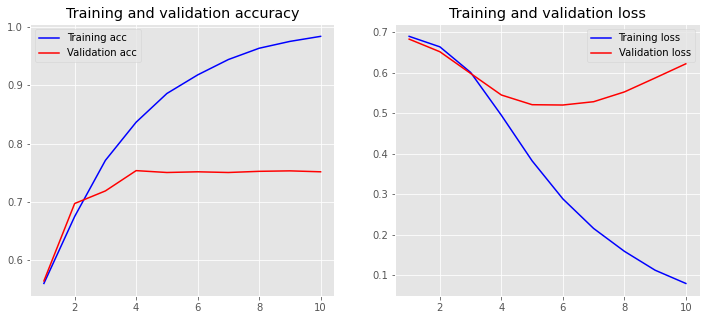

In [17]:
loss, accuracy = model.evaluate(X_train, target_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, target_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Let's see if we can improve this

## The Second model (using GloVe)

GloVe consist on some pretrained vectors for word embedding, here we're going to use those in order to create the embedding matrix, based on the result of the tokenizer
We will also add a global convolution 1D layer so as to process the relation between the words.

In [18]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
   vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
   embedding_matrix = np.zeros((vocab_size, embedding_dim))

   with open(filepath) as f:
      for line in f:
         word, *vector = line.split()
         if word in word_index:
            idx = word_index[word] 
            embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
   
   return embedding_matrix

In [19]:
embedding_dim_glove = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt', tokenizer.word_index, embedding_dim_glove)

In [20]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim_glove, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 50)            575500    
_________________________________________________________________
conv1d (Conv1D)              (None, 56, 128)           32128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 608,929
Trainable params: 608,929
Non-trainable params: 0
_________________________________________________________________


In [21]:
history2 = model2.fit(X_train, target_train, epochs=10, verbose=False, validation_data=(X_test, target_test), batch_size=150)

In [22]:
loss2, accuracy2 = model2.evaluate(X_train, target_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy2))
loss2, accuracy2 = model2.evaluate(X_test, target_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))

Training Accuracy: 0.9923
Testing Accuracy:  0.7204


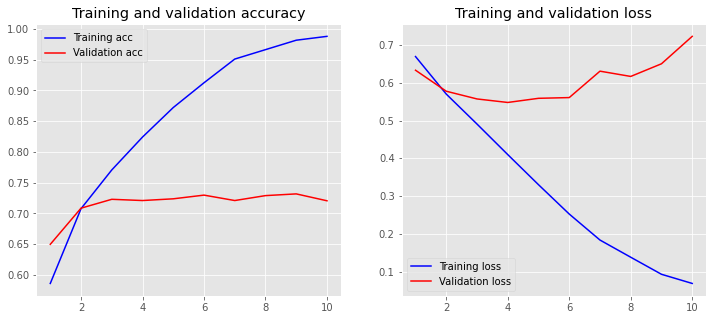

In [23]:
plot_history(history2)

## Third model (using lstm)

In [24]:
model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim_glove, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model3.add(SpatialDropout1D(0.1))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(Bidirectional(LSTM(4, return_sequences=True)))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(GlobalMaxPool1D())
model3.add(Dropout(0.25))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 60, 50)            575500    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 56, 128)           32128     
_________________________________________________________________
bidirectional (Bidirectional (None, 56, 8)             4256      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 52, 128)           5248      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [25]:
history3 = model3.fit(X_train, target_train, epochs=15, verbose=False, validation_data=(X_test, target_test), batch_size=150)

Training Accuracy: 0.9799
Testing Accuracy:  0.7196


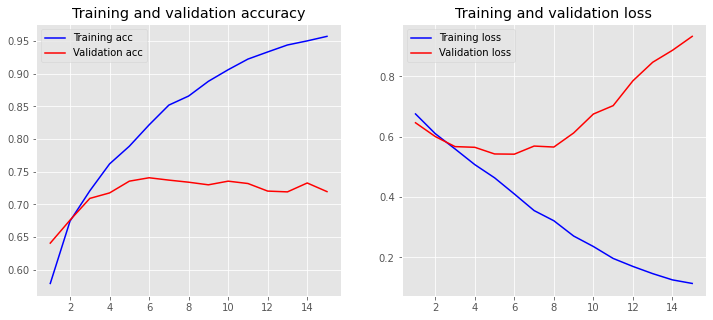

In [26]:
loss3, accuracy3 = model3.evaluate(X_train, target_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy3))
loss3, accuracy3 = model3.evaluate(X_test, target_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy3))
plot_history(history3)

## Checking model precision

In [27]:
def transform_sentences_to_sequences(sentences, tokenizer, maxlen):
   texts = tokenizer.texts_to_sequences(sentences)
   texts = pad_sequences(texts, padding='post', maxlen=maxlen)
   return texts

In [28]:

def to_cat(prediction):
   prediction[prediction > 0.5] = 1

def predict_all_model(texts, list_model, tokenizer):
   list_pred = []
   for model in list_model:
      texts_to_pred = transform_sentences_to_sequences(texts, tokenizer, maxlen=maxlen)
      pred = model.predict(texts_to_pred)
      pred = to_cat(pred)
      list_pred.append(pred)
   return list_pred

In [29]:
is_negative_test = tweets_global['target'] == 0
is_positive_test = tweets_global['target'] == 1

negatives = tweets_global[is_negative_test]
positives = tweets_global[is_positive_test]


test_positives = positives[5001:30000]
test_negatives = negatives[5001:30000]

# create a shuffled sample containing the same proportion of positive and negative than in the original file
test_example = pd.concat([test_positives, test_negatives])
test_example = test_example.sample(frac=1)

In [30]:
test_example['target'].replace({4: 1}, inplace=True)
test_example['text'] = test_example['text'].map(lambda x: cleaner(x))
text_to_pred = test_example['text']
target_values = test_example['target']

In [31]:

def predict_all_model(texts, list_model, tokenizer):
   list_pred = []
   for model in list_model:
      texts_to_pred = transform_sentences_to_sequences(texts, tokenizer, maxlen=maxlen)
      pred = model.predict(texts_to_pred)
      pred = pred.reshape(-1)
      pred[pred > 0.5] = 1
      pred[pred <= 0.5] = 0
      list_pred.append(pred)
   return list_pred


def get_confusion_matrix(list_prediction, actual_value):
   list_confusion_matrix = []
   for index, prediction in enumerate(list_prediction, start=1):
      column_name = 'Predicted_model{}'.format(index)
      data = {'y_Actual': actual_value.to_numpy(), 'y_Predicted_model': prediction}
      df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted_model'])
      confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted_model'], rownames=['Actual'], colnames=[column_name])
      list_confusion_matrix.append(confusion_matrix)
   return list_confusion_matrix

In [32]:
predictions = predict_all_model(text_to_pred, [model, model2, model3], tokenizer)
list_confusion_matrix = get_confusion_matrix(predictions, target_values)

In [33]:
for confusion_matrix in list_confusion_matrix:
    print(confusion_matrix, end='\n\n\n')

Predicted_model1    0.0    1.0
Actual                        
0                 17257   7742
1                  5439  19560


Predicted_model2    0.0    1.0
Actual                        
0                 15749   9250
1                  4882  20117


Predicted_model3    0.0    1.0
Actual                        
0                 15282   9717
1                  4507  20492




Those model have been tested on bigger datasets, in that case the model 3 is always better than the two other one